In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload

# always import gbm_algos first !
import xgboost, lightgbm, catboost

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
from torch.autograd import grad
import shap
from utils import *

from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

from tqdm import tqdm, trange

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[MLENS] backend: threading


In [2]:
DATA_PATH = "/Users/pongpisit/Desktop/research/pinn/Solving-Differential-Equations-with-Neural-Networks/SymbolicMathematics/data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 2000
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)

feature_names=['uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx']

Training with 2000 samples


In [3]:
class Network(nn.Module):
    def __init__(self, model):
        super(Network, self).__init__()
        self.model = model
        self.model.apply(self.xavier_init)
        # For tracking
        self.index2features = ('uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx')
        self.uf = None
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        self.uf = self.model(torch.cat([x, t], dim=1))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        
        ### PDE Loss calculation ###
        # first-order derivatives
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        # Homo second-order derivatives
        u_tt = self.gradients(u_t,t)[0]
        u_xx = self.gradients(u_x, x)[0]
        # Hetero second-order derivatives
        u_xt = self.gradients(u_t, x)[0]
        u_tx = self.gradients(u_x, t)[0]
        
        X_selector = torch.cat([uf, u_x, u_xx, u_tt, u_xt, u_tx], dim=1)
        y_selector = u_t
        
        return X_selector, y_selector
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [4]:
# Does the SeclectorNetwork has to be a neural networks ???
class SeclectorNetwork(nn.Module):
    def __init__(self, X_train_dim):
        super().__init__()
        # Nonlinear model, Training with noisy features -> chk feature importance
        layers = [nn.Linear(X_train_dim, 50), nn.Tanh(), nn.Linear(50, 1)]
        self.nonlinear_model = nn.Sequential(*layers)
        
    def forward(self, inn):
        ut_approx = self.nonlinear_model(inn)
        return ut_approx
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss

In [5]:
# network = Network(model=simple_solver_model(50))
# selector = SeclectorNetwork(X_train_dim=6)

# optimizer = torch.optim.LBFGS(list(network.parameters()) + list(selector.parameters()), 
#                               lr=5e-2, max_iter=80, max_eval=100, 
#                               history_size=120, line_search_fn='strong_wolfe')

# # optimizer = torch.optim.Adam(list(network.parameters()) + list(selector.parameters()), lr=1e-3)
# epochs = 5000; testing = False

# if testing:
#     # unsupervised_loss
#     unsup_loss = selector.loss(*network.get_selector_data(*dimension_slicing(X_u_train)))
#     sup_loss = F.mse_loss(network.uf, u_train)

#     # No MTL yet, apply the naive summation first to see if it's working?
#     total_loss = unsup_loss + sup_loss
#     print(total_loss)

#     total_loss.backward()

In [6]:
# network.train(); selector.train()
# curr_loss = 1000

# for i in range(epochs):
#     def closure():
#         optimizer.zero_grad()

#         # Total loss calculation process
#         # unsupervised_loss
#         unsup_loss = selector.loss(*network.get_selector_data(*dimension_slicing(X_u_train)))
#         sup_loss = F.mse_loss(network.uf, u_train)

#         # No MTL yet, apply the naive summation first to see if it's working?
#         total_loss = unsup_loss + sup_loss
#         total_loss.backward()
        
#         return total_loss
    
#     optimizer.step(closure)
    
#     l = closure()
#     if l.item() != curr_loss:
#         curr_loss = l.item()
#     else: break; print("Stop training.")
    
#     if (i % 10) == 0:
#         print("Epoch {}: ".format(i), curr_loss)

# print("Testing")
# network.eval()
# F.mse_loss(network(*dimension_slicing(X_star)).detach(), u_star) # Around 3e-3

### Using statistical models to find feature importance.

In [7]:
X_np = np.load("./saved_path_inverse_burger/data/derivatives-2000-V2.npy")
y_np = np.load("./saved_path_inverse_burger/data/dynamics-2000-V2.npy").ravel()

X_np_test = np.load("./saved_path_inverse_burger/data/derivatives-25600-V2.npy")
y_np_test = np.load("./saved_path_inverse_burger/data/dynamics-25600-V2.npy").ravel()

In [8]:
forest = RandomForestRegressor(n_estimators=200)
xg = xgboost.XGBRegressor(reg_alpha=0.1)
cat = catboost.CatBoostRegressor(iterations=None, depth=4, learning_rate=0.1, verbose=0, l2_leaf_reg=10)
light = lightgbm.LGBMRegressor(n_estimators=200, learning_rate=0.1, reg_lambda=1)

In [9]:
ensemble = SuperLearner(scorer=mean_squared_error, folds=3, model_selection=True, n_jobs=3)
ensemble.add([xg, light, cat])
ensemble.add_meta(forest)
ensemble.fit(X_np, y_np)

SuperLearner(array_check=None, backend=None, folds=3,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=3, raise_on_ex...0486310>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=True, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function mean_squared_error at 0x130486310>, shuffle=False,
       verbose=False)

In [10]:
sklearn_model = SklearnModel(model=ensemble, X_train=X_np, y_train=y_np, feature_names=feature_names)
print('Test MSE:', sklearn_model.test(X_np_test, y_np_test))
print('Training GBM algos...')
xg_feature_importance = SklearnModel(model=xg, X_train=X_np, y_train=y_np, feature_names=feature_names).feature_importance()
light_feature_importance = SklearnModel(model=light, X_train=X_np, y_train=y_np, feature_names=feature_names).feature_importance()
cat_feature_importance = SklearnModel(model=cat, X_train=X_np, y_train=y_np, feature_names=feature_names).feature_importance()

Done training
Training MSE: 0.0066034985
Test MSE: 0.033310343
Training GBM algos...
Done training
Training MSE: 0.0001727756
('u_xx', 0.2995062425806188)
('u_x', 0.2657608052229761)
('uf', 0.17712287340875157)
('u_tt', 0.14668808658885826)
('u_xt', 0.1109219921987952)
('u_tx', 0.0)
Done training
Training MSE: 0.020548649252686554
('u_xx', 0.277)
('u_x', 0.2575)
('uf', 0.16683333333333333)
('u_tt', 0.16233333333333333)
('u_xt', 0.13633333333333333)
('u_tx', 0.0)
Done training
Training MSE: 0.000988400443332225
('u_x', 0.4000971603499)
('uf', 0.33517344012767003)
('u_xx', 0.13600354654803215)
('u_tt', 0.09044096517279519)
('u_tx', 0.019700376078911026)
('u_xt', 0.01858451172269141)


In [11]:
xg_feature_importance = SklearnModel(model=xg, X_train=X_np, y_train=y_np, feature_names=feature_names).feature_importance()
light_feature_importance = SklearnModel(model=light, X_train=X_np, y_train=y_np, feature_names=feature_names).feature_importance()
cat_feature_importance = SklearnModel(model=cat, X_train=X_np, y_train=y_np, feature_names=feature_names).feature_importance()

Done training
Training MSE: 0.0001727756
('u_xx', 0.2995062425806188)
('u_x', 0.2657608052229761)
('uf', 0.17712287340875157)
('u_tt', 0.14668808658885826)
('u_xt', 0.1109219921987952)
('u_tx', 0.0)
Done training
Training MSE: 0.020548649252686554
('u_xx', 0.277)
('u_x', 0.2575)
('uf', 0.16683333333333333)
('u_tt', 0.16233333333333333)
('u_xt', 0.13633333333333333)
('u_tx', 0.0)
Done training
Training MSE: 0.000988400443332225
('u_x', 0.4000971603499)
('uf', 0.33517344012767003)
('u_xx', 0.13600354654803215)
('u_tt', 0.09044096517279519)
('u_tx', 0.019700376078911026)
('u_xt', 0.01858451172269141)


In [12]:
avg_feature_importances = {}
for f in feature_names:
    avg_feature_importances[f] = (xg_feature_importance[f]+cat_feature_importance[f]+light_feature_importance[f])/3
avg_feature_importances

{'uf': 0.17712287340875157,
 'u_x': 0.2657608052229761,
 'u_xx': 0.2995062425806188,
 'u_tt': 0.14668808658885826,
 'u_xt': 0.11092199219879521,
 'u_tx': 0.0}

In [13]:
# explainer = shap.Explainer(xg)
# shap_values = explainer(X_np)

# explainer = shap.explainers.Exact(ensemble.predict, X_np) # OK Features [0, 1, 2] are the best!
# shap_values = explainer(X_np)

# shap.plots.bar(shap_values)

In [14]:
# NEED TO PREPROCESS!!!
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
scaler = MinMaxScaler()
scaled_X_np = scaler.fit_transform(X_np)

In [15]:
# The old version of a (big) MLP.
# mlp = TorchMLP([6, 512, 512, 512, 1])
# mlp.load_state_dict(torch.load("./saved_path_inverse_burger/mlp.pth"))

# I should add batch normalization mec.
layers = [6, 200, 200, 1]
# Don't use nn.Dropout here & load the linear weights with strict=False
mlp = TorchMLP(dimensions=layers, bn=nn.LayerNorm, dropout=nn.Dropout(0.1), inp_drop=False)

In [16]:
scaled_X_tensor = to_tensor(scaled_X_np)
y_tensor = to_tensor(y_np).reshape(-1, 1)

mlp_optim = torch.optim.LBFGS(mlp.parameters(), 
                              lr=5e-2, max_iter=100, max_eval=125, 
                              history_size=120, line_search_fn='strong_wolfe')
mlp.train()
epochs = 1000; curr_loss = 1000
for i in range(epochs):
    def mlp_closure():
        mlp_optim.zero_grad()
        l = F.mse_loss(mlp(scaled_X_tensor), y_tensor)
        l.backward()
        return l
    mlp_optim.step(mlp_closure)
    
    l = mlp_closure()
    if l.item() != curr_loss:
        curr_loss = l.item()
    else: break; print("Stop training.")
    
    if (i % 10) == 0:
        print("Epoch {}: ".format(i), curr_loss)

Epoch 0:  0.3627060651779175
Epoch 10:  0.003476891666650772
Epoch 20:  0.001006736303679645
Epoch 30:  0.000789798388723284
Epoch 40:  0.0006843773298896849


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


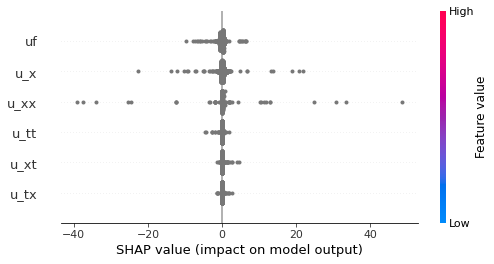

In [17]:
mlp.eval()
e = shap.DeepExplainer(mlp, scaled_X_tensor)
shap_values = e.shap_values(scaled_X_tensor)
shap.summary_plot(shap_values, features=scaled_X_tensor, feature_names=feature_names)

In [18]:
# torch.save(mlp.state_dict(), "./saved_path_inverse_burger/mlp200*3.pth")